In [1]:
import re
import nltk
import math
import pandas as pd
import numpy as np
from underthesea import word_tokenize
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\underthesea\utils\__init__.py:12: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  device = torch.device("cpu")


# 1. Tiền xử lý dữ liệu

## 1.1 Đọc dữ liệu

In [2]:
def readFile(file_name):
    lines = []
    with open(file_name, 'r', encoding= 'utf-8') as f:
        for line in f:
            if line != '\n':
                line = line.replace('\n', '').replace('“', '"').replace('”', '"').replace('…', '...').replace('’',"'")
                lines.append(line)
    return lines
# .encode('ascii', 'ignore').decode('ascii')
train_lines = readFile('./dataset/POS/vi_train.pos')
test_lines = readFile('./dataset/POS/vi_test.pos')

print('len train:', len(train_lines))
print('len test:', len(test_lines))
train_lines[:3]

len train: 8495
len test: 1051


['Trên/E đường/N đi/V ,/, có/V một/M lần/N xe/N cô/N suýt/R rơi/V xuống/R vực/N ở/E đèo/N Ngoạn_Mục/Np ./.',
 'Trong/E một/M trận/N đánh/V ác_liệt/A bên/N thành/N cổ/N Quảng_Trị/Np ,/, một/M loạt/N đạn/N pháo/N của/E kẻ_thù/N đã/R rơi/V trúng/A chỗ/N chiến_sĩ/N thông_tin/N Nguyễn_Văn_Thạc/Np .../... Hôm/N đó/P ngày/N 30/M -/- 7/M -/- 1972/M ./.',
 'Sau/E khi/N H./Ny "/" AK/Ny "/" bị/V xộ/V khám/V ,/, Hoàng/Np đã/R hoàn_lương/V ,/, bây_giờ/P đang/R phụ/V việc/N cho/E gia_đình/N Quân/Np ./.']

## 1.2 Tách dữ liệu thành các sentences, tags

In [3]:
def split_sentences_tags(data):
    sentences = []
    tags = []
    for line in data:        # line = 'Trên/E đường/N đi/V'
        try: 
            _sent = []
            _tag = []
            word_tag = line.split()     # word_tag = ['Trên/E', 'đường/N', 'đi/V']
            for wt in word_tag:
                word, tag = wt.split('/')
                if tag != '' and word != '':
                    _sent.append(word)
                    _tag.append(tag)
            sentences.append(_sent)
            tags.append(_tag)
        except:
            pass
    return sentences, tags

###############################################################
train_sentences, train_tags = split_sentences_tags(train_lines)
test_sentences, test_tags = split_sentences_tags(test_lines)

In [4]:
print(len(train_sentences))
for i in range(3):
    print(train_sentences[i])
    print(train_tags[i])
    print()

8343
['Trên', 'đường', 'đi', ',', 'có', 'một', 'lần', 'xe', 'cô', 'suýt', 'rơi', 'xuống', 'vực', 'ở', 'đèo', 'Ngoạn_Mục', '.']
['E', 'N', 'V', ',', 'V', 'M', 'N', 'N', 'N', 'R', 'V', 'R', 'N', 'E', 'N', 'Np', '.']

['Trong', 'một', 'trận', 'đánh', 'ác_liệt', 'bên', 'thành', 'cổ', 'Quảng_Trị', ',', 'một', 'loạt', 'đạn', 'pháo', 'của', 'kẻ_thù', 'đã', 'rơi', 'trúng', 'chỗ', 'chiến_sĩ', 'thông_tin', 'Nguyễn_Văn_Thạc', '...', 'Hôm', 'đó', 'ngày', '30', '-', '7', '-', '1972', '.']
['E', 'M', 'N', 'V', 'A', 'N', 'N', 'N', 'Np', ',', 'M', 'N', 'N', 'N', 'E', 'N', 'R', 'V', 'A', 'N', 'N', 'N', 'Np', '...', 'N', 'P', 'N', 'M', '-', 'M', '-', 'M', '.']

['Sau', 'khi', 'H.', '"', 'AK', '"', 'bị', 'xộ', 'khám', ',', 'Hoàng', 'đã', 'hoàn_lương', ',', 'bây_giờ', 'đang', 'phụ', 'việc', 'cho', 'gia_đình', 'Quân', '.']
['E', 'N', 'Ny', '"', 'Ny', '"', 'V', 'V', 'V', ',', 'Np', 'R', 'V', ',', 'P', 'R', 'V', 'N', 'E', 'N', 'Np', '.']



# 2. HMM - Hidden Markov Models

## 2.1 Tiền xử lý dữ liệu

In [5]:
# chia: tag, tagtag, wordtag
def get_tag_tagtag_wordtag(sent):
    tag = []
    tagtag = []
    wordtag = []
    wt = sent.split()               # ['word/tag',...]
    for i in range(len(wt)-1):
        wt1 = wt[i].split('/')      # word1   tag1
        wt2 = wt[i+1].split('/')    # word2   tag2
        if wt1[1] != '' and wt2[1] != '':
            if i==0:
                tag.append('T0')
                tag.append(wt1[1])
                tagtag.append('T0'+'/'+wt1[1])
            tag.append(wt2[1])         
            tagtag.append(wt1[1]+'/'+wt2[1])        
            wordtag.append(wt[i])
            if (i == len(wt)-2):
                wordtag.append(wt[i+1])
        
    return tag,tagtag,wordtag

In [6]:
# tổng hợp dữ liệu từ file train
tag_all=[]
tagtag_all=[]
wordtag_all=[]
for sent in train_lines:
    try:
        tag, tagtag, wordtag = get_tag_tagtag_wordtag(sent)
    
        tag_all.extend(tag)
        tagtag_all.extend(tagtag)
        wordtag_all.extend(wordtag)
    except:
        continue

In [7]:
from collections import Counter
# đếm tần suất cho tập Train
COUNTER_TAG = Counter(tag_all)
COUNTER_TAG_TAG = Counter(tagtag_all)
COUNTER_WORD_TAG = Counter(wordtag_all)

In [8]:
tags = [tag for tag in COUNTER_TAG.keys()]
print(len(tags))
print(tags)

52
['T0', 'E', 'N', 'V', ',', 'M', 'R', 'Np', '.', 'A', '...', 'P', '-', 'Ny', '"', ':', 'L', 'C', 'Nc', 'X', '(', ')', 'Nu', 'Nb', 'T', '!', '&', 'S', ';', 'Ap', '?', 'B', '*', 'I', 'Y', ']', '>', 'Vy', 'Vb', '.)', 'Ab', "'", 'p', 'NY', '~', 'NC', 'a', 'Eb', 'H', '+', 'm', 'v']


In [9]:
# tính tham số model
V = len(tag_all)
alpha = 0.001
# compute  Transition Probability
def p_tagtag(tag1,tag2):
    tag_tag = '/'.join([tag1,tag2])
    return math.log((COUNTER_TAG_TAG[tag_tag] + alpha) / (COUNTER_TAG[tag1] + V*alpha))

# compute Emission Probability
def p_wordtag(word,tag):
    word_tag = '/'.join([word,tag])
    return math.log((COUNTER_WORD_TAG[word_tag] + alpha) / (COUNTER_TAG[tag] + V*alpha))

In [10]:
# ma trận xác suất tag_tag
tags_matrix = np.zeros((len(tags),len(tags)))
for i in range(len(tags)):
    for j in range(len(tags)):
        tags_matrix[i][j] = p_tagtag(tags[i],tags[j])
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,T0,E,N,V,",",M,R,Np,.,A,...,p,NY,~,NC,a,Eb,H,+,m,v
T0,-15.961118,-2.416103,-1.418542,-2.212815,-15.961118,-3.248225,-2.801457,-3.131782,-15.961118,-3.380036,...,-15.961118,-15.961118,-15.961118,-15.961118,-15.961118,-15.961118,-15.961118,-15.961118,-15.961118,-15.961118
E,-16.307329,-4.764835,-0.718732,-2.608351,-7.607648,-2.934984,-4.563284,-2.583933,-9.398574,-3.634380,...,-16.307329,-16.307329,-16.307329,-16.307329,-16.307329,-16.307329,-16.307329,-16.307329,-16.307329,-16.307329
N,-17.629352,-2.629663,-1.724326,-1.552287,-2.622346,-3.350107,-2.682439,-2.917345,-3.132767,-2.391698,...,-17.629352,-17.629352,-17.629352,-17.629352,-17.629352,-17.629352,-17.629352,-17.629352,-10.720598,-17.629352
V,-17.442787,-2.371090,-1.336865,-1.664228,-3.176200,-3.354199,-2.452938,-4.044306,-3.468564,-2.742682,...,-17.442787,-17.442787,-17.442787,-17.442787,-10.534032,-17.442787,-10.534032,-17.442787,-17.442787,-17.442787
",",-16.173931,-2.989530,-1.340656,-1.678864,-16.173931,-3.195435,-2.577819,-2.589091,-16.173931,-2.865916,...,-16.173931,-16.173931,-16.173931,-16.173931,-16.173931,-16.173931,-16.173931,-16.173931,-16.173931,-16.173931
M,-15.802457,-3.701740,-0.801545,-4.004345,-2.763473,-3.460976,-4.646193,-5.339325,-3.857743,-5.850132,...,-15.802457,-15.802457,-15.802457,-8.893703,-15.802457,-15.802457,-15.802457,-15.802457,-15.802457,-15.802457
R,-16.468910,-3.374944,-2.678716,-0.714801,-3.554799,-3.410550,-2.583872,-5.500694,-3.655790,-2.142373,...,-16.468910,-16.468910,-16.468910,-16.468910,-16.468910,-16.468910,-16.468910,-16.468910,-16.468910,-16.468910
Np,-15.853639,-2.990044,-3.424419,-1.442043,-1.644061,-4.086064,-2.191279,-4.391997,-2.623317,-3.444622,...,-15.853639,-15.853639,-15.853639,-15.853639,-15.853639,-15.853639,-15.853639,-15.853639,-15.853639,-8.944885
.,-15.795854,-15.795854,-8.887099,-15.795854,-8.194452,-15.795854,-8.194452,-15.795854,-8.887099,-15.795854,...,-15.795854,-15.795854,-15.795854,-15.795854,-15.795854,-15.795854,-15.795854,-15.795854,-15.795854,-15.795854
A,-16.303183,-2.188308,-1.893240,-2.079543,-2.077551,-2.978694,-2.510940,-5.025967,-2.540018,-2.868931,...,-16.303183,-16.303183,-16.303183,-16.303183,-16.303183,-16.303183,-16.303183,-16.303183,-16.303183,-16.303183


## 2.2 Xây dựng thuật toán Viterbi

In [11]:
# sử dụng thuật toán viterbi để gán nhãn cho câu sent
def Viterbi(words, tag_keys = tags):
    state = []
    for i, word in enumerate(words):
        p = []
        for tag in tag_keys:
            if i == 0:
                 transition_p = tags_df.loc['T0', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            emission_p = p_wordtag(word,tag)
            state_probability = emission_p + transition_p    
            p.append(state_probability)
             
        pmax = max(p)

        state_max = tag_keys[p.index(pmax)] 
        state.append(state_max)
    
    return list(zip(words, state))

## 2.3 Dự đoán

In [12]:
# Testing
#test
y_pred_test_HMM = []
for test_sent in test_sentences:
    y_pred_test_HMM.append([word_state[1] for word_state in Viterbi(test_sent)])
#train
y_pred_train_HMM = []
for train_sent in train_sentences:
    y_pred_train_HMM.append([word_state[1] for word_state in Viterbi(train_sent)])

In [13]:
# test
y_test_tag_HMM = [tag for sent_tags in test_tags for tag in sent_tags]
y_pred_test_tag_HMM = [tag for sent_tags in y_pred_test_HMM for tag in sent_tags]
# tag
y_train_tag_HMM = [tag for sent_tags in train_tags for tag in sent_tags]
y_pred_train_tag_HMM = [tag for sent_tags in y_pred_train_HMM for tag in sent_tags]

## 2.4 Đánh giá mô hình

In [14]:
# test
acc_test_HMM = accuracy_score(y_test_tag_HMM, y_pred_test_tag_HMM)
f1_test_HMM = f1_score(y_test_tag_HMM, y_pred_test_tag_HMM, average='weighted')
#train
acc_train_HMM = accuracy_score(y_train_tag_HMM, y_pred_train_tag_HMM)
f1_train_HMM = f1_score(y_train_tag_HMM, y_pred_train_tag_HMM, average='weighted')

print('(Test) accuracy_score', acc_test_HMM)
print('(Test) f1_score', f1_test_HMM)
print('(Train) accuracy_score', acc_train_HMM)
print('(Train) f1_score', f1_train_HMM)

(Test) accuracy_score 0.893992315752707
(Test) f1_score 0.8949391980329365
(Train) accuracy_score 0.9249225803409085
(Train) f1_score 0.9239718079616922


In [15]:
compare_model = {} 
compare_model['HMM'] = {'acc_test': acc_test_HMM, 
                        'f1_test': f1_test_HMM,
                        'acc_train': acc_train_HMM,
                        'f1_train': f1_train_HMM}

## 2.5 Xây dựng hàm gán nhãn cho từng câu với HMM

In [16]:
def POSTagging_HMM(sent):
    words = word_tokenize(sent, format='text').split()
    return Viterbi(words)
sent = 'Hôm nay đi học trời đẹp quá đi ta ơi.'
POSTagging_HMM(sent)

[('Hôm_nay', 'N'),
 ('đi', 'V'),
 ('học', 'V'),
 ('trời', 'N'),
 ('đẹp', 'A'),
 ('quá', 'R'),
 ('đi', 'V'),
 ('ta', 'P'),
 ('ơi', 'T'),
 ('.', '.')]

# 3. CRF - Conditional Random Field

## 3.1 Tiền xử lý dữ liệu

In [4]:
def features(sentence,index):
    return {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'curr_word': sentence[index],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
    }

In [5]:
def prepareData(tagged_sentences):
    X=[]
    for sentences in tagged_sentences:
        X.append([features(sentences, index) for index in range(len(sentences))])
    return X

In [6]:
X_train_CRF = prepareData(train_sentences)
y_train_CRF = train_tags
X_test_CRF = prepareData(test_sentences)
y_test_CRF =  test_tags

In [7]:
X_train_CRF[0]

[{'is_first_capital': 1,
  'is_first_word': 1,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': '',
  'next_word': 'đường',
  'curr_word': 'Trên',
  'is_numeric': 0,
  'is_alphanumeric': 0},
 {'is_first_capital': 0,
  'is_first_word': 0,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': 'Trên',
  'next_word': 'đi',
  'curr_word': 'đường',
  'is_numeric': 0,
  'is_alphanumeric': 0},
 {'is_first_capital': 0,
  'is_first_word': 0,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': 'đường',
  'next_word': ',',
  'curr_word': 'đi',
  'is_numeric': 0,
  'is_alphanumeric': 0},
 {'is_first_capital': 0,
  'is_first_word': 0,
  'is_last_word': 0,
  'is_complete_capital': 1,
  'prev_word': 'đi',
  'next_word': 'có',
  'curr_word': ',',
  'is_numeric': 0,
  'is_alphanumeric': 0},
 {'is_first_capital': 0,
  'is_first_word': 0,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': ',',
  'next_word': 'một',
  'curr_word': 'có',
  'is_numeric': 0,
 

## 3.2 Xây dựng mô hình CRF và huấn luyện mô hình

In [8]:
from sklearn_crfsuite import CRF

crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

try:
    crf.fit(X_train_CRF, y_train_CRF)
except AttributeError:
    pass

## 3.3 Dự đoán

In [9]:
y_pred_test_CRF = crf.predict(X_test_CRF)
y_pred_train_CRF = crf.predict(X_train_CRF)

## 3.4 Đánh giá mô hình

In [10]:
from sklearn_crfsuite import metrics, scorers

# test
acc_test_CRF = metrics.flat_accuracy_score(y_test_CRF, y_pred_test_CRF)
f1_test_CRF = metrics.flat_f1_score(y_test_CRF, y_pred_test_CRF,average='weighted',labels=crf.classes_)
#train
acc_train_CRF = metrics.flat_accuracy_score(y_train_CRF, y_pred_train_CRF)
f1_train_CRF = metrics.flat_f1_score(y_train_CRF, y_pred_train_CRF,average='weighted',labels=crf.classes_)

print('(Test) accuracy_score', acc_test_CRF)
print('(Test) f1_score', f1_test_CRF)
print('(Train) accuracy_score', acc_train_CRF)
print('(Train) f1_score', f1_train_CRF)

(Test) accuracy_score 0.9286150890674119
(Test) f1_score 0.9275321698798644
(Train) accuracy_score 0.9734965390399438
(Train) f1_score 0.9734036596715994


In [22]:
from sklearn_crfsuite import metrics, scorers

# test
acc_test_CRF = metrics.flat_accuracy_score(y_test_CRF, y_pred_test_CRF)
f1_test_CRF = metrics.flat_f1_score(y_test_CRF, y_pred_test_CRF,average='weighted',labels=crf.classes_)
#train
acc_train_CRF = metrics.flat_accuracy_score(y_train_CRF, y_pred_train_CRF)
f1_train_CRF = metrics.flat_f1_score(y_train_CRF, y_pred_train_CRF,average='weighted',labels=crf.classes_)

print('(Test) accuracy_score', acc_test_CRF)
print('(Test) f1_score', f1_test_CRF)
print('(Train) accuracy_score', acc_train_CRF)
print('(Train) f1_score', f1_train_CRF)

(Test) accuracy_score 0.9330684596577017
(Test) f1_score 0.9324825708177754
(Train) accuracy_score 0.9745550007073878
(Train) f1_score 0.9744800026579821


In [23]:
compare_model['CRF'] = {'acc_test': acc_test_CRF, 
                        'f1_test': f1_test_CRF,
                        'acc_train': acc_train_CRF,
                        'f1_train': f1_train_CRF}

## 3.5 Xây dựng hàm gán nhãn cho từng câu với CRF

In [24]:
def POSTagging_CRF(sent):
    # sent = nltk.word_tokenize(sent.lower())
    words = word_tokenize(sent, format='text').split()
    x_data = prepareData([words])
    y_pred = crf.predict(x_data)
    return list(zip(words, y_pred[0]))

sent = 'Hôm nay đi học trời đẹp quá đi ta ơi.'
POSTagging_CRF(sent)

[('Hôm_nay', 'N'),
 ('đi', 'V'),
 ('học', 'V'),
 ('trời', 'N'),
 ('đẹp', 'A'),
 ('quá', 'R'),
 ('đi', 'V'),
 ('ta', 'P'),
 ('ơi', 'I'),
 ('.', '.')]

# 4. Logistic Regression

## 4.1 Tiền xử lý dữ liệu

In [25]:
X_train_features_LR = [dict for sent in prepareData(train_sentences) for dict in sent]
X_test_features_LR = [dict for sent in prepareData(test_sentences) for dict in sent]

In [26]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X_train_LR = vec.fit_transform(X_train_features_LR)
X_test_LR = vec.transform(X_test_features_LR)

y_train_LR = [tag for label in train_tags for tag in label]
y_test_LR = [tag for label in test_tags for tag in label]

## 4.2 Xây dựng và huấn luyện mô hình LogisticRegression

In [27]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_LR, y_train_LR)

LogisticRegression()

## 4.3 Dự đoán

In [28]:
y_pred_test_LR = LR.predict(X_test_LR)
y_pred_train_LR = LR.predict(X_train_LR)

## 4.4 Đánh giá mô hình

In [29]:
# test
acc_test_LR = accuracy_score(y_test_LR, y_pred_test_LR)
f1_test_LR = f1_score(y_test_LR, y_pred_test_LR, average='weighted')
#train
acc_train_LR = accuracy_score(y_train_LR, y_pred_train_LR)
f1_train_LR = f1_score(y_train_LR, y_pred_train_LR, average='weighted')

print('(Test) accuracy_score', acc_test_LR)
print('(Test) f1_score', f1_test_LR)
print('(Train) accuracy_score', acc_train_LR)
print('(Train) f1_score', f1_train_LR)

(Test) accuracy_score 0.9308417743625568
(Test) f1_score 0.9299305748065868
(Train) accuracy_score 0.9583270017763292
(Train) f1_score 0.9579606870069117


In [30]:
compare_model['LR'] = {'acc_test': acc_test_LR, 
                        'f1_test': f1_test_LR,
                        'acc_train': acc_train_LR,
                        'f1_train': f1_train_LR}

## 4.5 Xây dựng hàm gán nhãn cho từng câu với LogisticRegression

In [31]:
def POSTagging_LR(sent):
    words = word_tokenize(sent, format='text').split()
    x_data = [dict for sent in prepareData([words]) for dict in sent]
    x_data = vec.transform(x_data)
    y_pred = LR.predict(x_data)
    return list(zip(words, y_pred))

sent = 'Hôm nay đi học trời đẹp quá đi ta ơi.'
POSTagging_LR(sent)

[('Hôm_nay', 'N'),
 ('đi', 'V'),
 ('học', 'V'),
 ('trời', 'N'),
 ('đẹp', 'A'),
 ('quá', 'R'),
 ('đi', 'V'),
 ('ta', 'P'),
 ('ơi', 'I'),
 ('.', '.')]

# 5. So sánh các mô hình

In [32]:
df_compare = pd.DataFrame(compare_model).T
df_compare.style.highlight_max(color = 'green', axis = 0)

,acc_test,f1_test,acc_train,f1_train
HMM,0.893992,0.894939,0.924923,0.923972
CRF,0.933068,0.932483,0.974555,0.974480
LR,0.930842,0.929931,0.958327,0.957961


<AxesSubplot:>

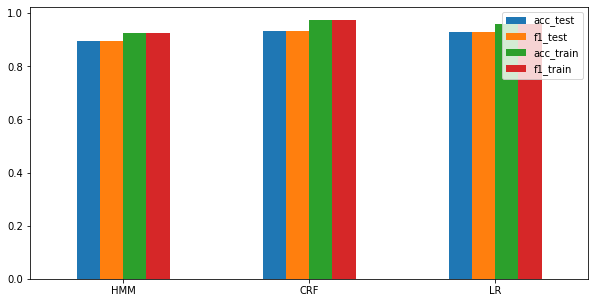

In [33]:
df_compare.plot(kind="bar", figsize=(10,5), rot=0)